# Momsitter Payment count Versus Location Analysis

각 지역별 가입수와 결제 건수간의 어떤 상관 관계가 있는지 분석하기 위한 노트. 특정 지역의 변화에 미감하게 결제건수가 반응한다면, 해당 지역의 부모 혹은 시터 수에 결제율이 큰 팩터가 된다고 할 수 있다. 이 노트에서는 시간에 따른 부모 시터의 비공개 상태 전환은 even 하다고 가정을 한 후, 해당 팩터에 대한 영향 배제하고 분석을 실시.

In [192]:
# 라이브러리 로드
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats.stats import pearsonr
import operator

In [193]:
# 분석 대상이 되는 데이터 로드
locationDic = pd.read_json('./04-data/locationDic.json', typ='series')
parentLocation = pd.read_json('./04-data/parentLocation.json')
sitterLocation = pd.read_json('./04-data/sitterLocation.json')
parentPaymentData = pd.read_json('./04-data/parentPaymentData.json')
sitterPaymentData = pd.read_json('./04-data/sitterPaymentData.json')

In [194]:
locationDic

                  263
null null          48
강원도 강릉시           123
강원도 동해시           224
강원도 삼척시           223
강원도 속초시           166
강원도 영월군           228
강원도 원주시           124
강원도 인제군           187
강원도 정선군           264
강원도 철원군           178
강원도 춘천시            54
강원도 평창군           195
강원도 홍천군           184
경기도 가평군           190
경기도 고양시           208
경기도 고양시 덕양구        77
경기도 고양시 일산동구       92
경기도 고양시 일산서구       94
경기도 고양시덕양구        242
경기도 고양시일산동구       241
경기도 과천시           106
경기도 광명시           102
경기도 광주시           151
경기도 구리시           141
경기도 군포시           114
경기도 김포시           143
경기도 남양주시           34
경기도 동두천시          136
경기도 부천시            19
                 ... 
충청남도 아산시          163
충청남도 아산시배방읍       230
충청남도 아산시탕정면       231
충청남도 예산군          244
충청남도 천안시          216
충청남도 천안시 동남구      110
충청남도 천안시 서북구       30
충청남도 천안시동남구       222
충청남도 천안시동남구신부동    232
충청남도 천안시서북구       206
충청남도 청양군          129
충청남도 태안군          189
충청남도 홍성군          171
충청북도 괴산군          253
충청북도 보은군  

In [195]:
parentLocation.head()

,1,10,100,101,102,103,104,105,106,107,...,90,91,92,93,94,95,96,97,98,99
2017-11-01,18,7,3,1,9,2,2,2,2,4,...,9,3,8,16,4,9,5,4,2,0
2017-12-01,9,11,8,4,11,3,0,4,1,1,...,6,11,10,19,5,10,6,4,2,3
2018-01-01,18,5,6,4,12,5,0,2,0,2,...,3,7,8,12,6,12,7,4,5,1
2018-02-01,21,6,8,8,6,6,0,6,2,7,...,11,4,17,28,12,11,10,4,6,4
2018-03-01,14,6,4,5,9,4,1,4,1,7,...,9,5,9,16,10,10,9,7,0,5


In [196]:
sitterLocation.head()

,1,10,100,101,102,103,104,105,106,107,...,90,91,92,93,94,95,96,97,98,99
2017-11-01,20,12,9,8,11,3,1,3,1,3,...,14,5,7,5,7,8,7,14,3,2
2017-12-01,28,14,10,17,24,2,8,10,0,3,...,19,6,33,24,24,12,27,13,2,9
2018-01-01,38,12,8,6,18,6,3,10,1,4,...,13,14,26,15,17,9,8,13,4,8
2018-02-01,34,8,5,13,17,1,0,6,2,12,...,16,6,26,24,16,3,13,6,0,6
2018-03-01,77,29,16,23,26,16,13,11,6,28,...,14,14,35,60,35,6,98,20,3,10


In [197]:
parentPaymentData

,paymentCount,paymentDate
0,338,2017-11
1,458,2017-12
2,509,2018-01
3,510,2018-02
4,530,2018-03
5,496,2018-04


In [198]:
sitterPaymentData

,paymentCount,paymentDate
0,27,2017-11
1,65,2017-12
2,80,2018-01
3,45,2018-02
4,100,2018-03
5,81,2018-04


## Data Normalization

In [199]:
parent_loc_norm = (parentLocation - parentLocation.mean()) / (parentLocation.max() - parentLocation.min())
sitter_loc_norm = (sitterLocation - sitterLocation.mean()) / (sitterLocation.max() - sitterLocation.min())

parentPaymentCount = parentPaymentData['paymentCount']
sitterPaymentCount = sitterPaymentData['paymentCount']

parent_payment_norm = (parentPaymentCount - parentPaymentCount.mean()) / (parentPaymentCount.max() - parentPaymentCount.min())
sitter_payment_norm = (sitterPaymentCount - sitterPaymentCount.mean()) / (sitterPaymentCount.max() - sitterPaymentCount.min())

## Calculate Pearson correlation coefficient

In [200]:
# 부모 지역-부모 결제 데이터간 상관계수 결과값
cor_parent_location_vs_parent_payment = {}

# 부모 지역-시터 결제 데이터간 상관계수 결과값
cor_parent_location_vs_sitter_payment = {}

# 시터 지역-부모 결제 데이터간 상관계수 결과값
cor_sitter_location_vs_parent_payment = {}

# 시터 지역-시터 결제 데이터간 상관계수 결과값
cor_sitter_location_vs_sitter_payment = {}

In [201]:
# 상관계수 계산 
for location in parent_loc_norm.columns:
    locationData = parent_loc_norm[location].tolist()
    cor_parent_location_vs_parent_payment[location] = pearsonr(locationData, parentPaymentCount.tolist())[0]
    
for location in parent_loc_norm.columns:
    locationData = parent_loc_norm[location].tolist()
    cor_parent_location_vs_sitter_payment[location] = pearsonr(locationData, sitterPaymentCount.tolist())[0]
    
for location in sitter_loc_norm.columns:
    locationData = sitter_loc_norm[location].tolist()
    cor_sitter_location_vs_parent_payment[location] = pearsonr(locationData, parentPaymentCount.tolist())[0]
    
for location in sitter_loc_norm.columns:
    locationData = sitter_loc_norm[location].tolist()
    cor_sitter_location_vs_sitter_payment[location] = pearsonr(locationData, sitterPaymentCount.tolist())[0]

In [202]:
cor_parent_location_vs_parent_payment

{1L: 0.08484066014498799,
 2L: -0.24163179445893482,
 3L: -0.03407351499974888,
 4L: 0.4550276490857989,
 5L: 0.3323007617169978,
 6L: 0.8393076816230135,
 7L: 0.31826533140762786,
 8L: 0.5491354053522143,
 9L: 0.704749094592513,
 10L: -0.3296220077401588,
 11L: 0.025099172881888406,
 12L: 0.43227419150188867,
 13L: -0.1550205569666614,
 14L: 0.3226130748035914,
 15L: 0.5728338274396493,
 16L: 0.60706424545685,
 17L: 0.4789399622295481,
 18L: 0.7753730978975037,
 19L: 0.4775685338141632,
 20L: 0.438260711885889,
 21L: 0.7502813547435169,
 22L: 0.48905831212826967,
 23L: -0.016870904339460428,
 24L: 0.6285235957884455,
 25L: 0.7769860377181466,
 26L: 0.38916448445295926,
 27L: 0.5104909483784735,
 28L: -0.21883369137813055,
 29L: -0.43364284862257435,
 30L: 0.5395930562250522,
 31L: 0.5782042529412348,
 32L: -0.08848985683061049,
 33L: 0.18769220963876243,
 34L: -0.07673015351196576,
 35L: 0.27817745784373793,
 36L: 0.37523002691034724,
 37L: 0.008100500969482347,
 38L: 0.49203822217949

### Parent location versus Parent payment count

In [203]:
# average pearson correlation (p-value)
p_sum = 0;
for k, v in cor_parent_location_vs_parent_payment.iteritems():
    p_sum += v
    
p_avg = p_sum / len(cor_parent_location_vs_parent_payment)
print p_avg

0.2722852717198035


In [204]:
# ranking (sort) p-value (desc)
sorted_cor_plpp = sorted(cor_parent_location_vs_parent_payment.items(), key=operator.itemgetter(1), reverse=True)
sorted_cor_plpp

[(121L, 0.9317803189757722),
 (108L, 0.9072946549443058),
 (72L, 0.8615327149778743),
 (6L, 0.8393076816230135),
 (152L, 0.8174686513335123),
 (73L, 0.8144522220693243),
 (75L, 0.7971220832136664),
 (41L, 0.7948078746570768),
 (101L, 0.7926431856529157),
 (103L, 0.7917199003046067),
 (126L, 0.7861224916959518),
 (25L, 0.7769860377181466),
 (18L, 0.7753730978975037),
 (78L, 0.7676403617585444),
 (61L, 0.7575338263492488),
 (74L, 0.7518005308306059),
 (21L, 0.7502813547435169),
 (117L, 0.7482042325122222),
 (141L, 0.7433989865050621),
 (99L, 0.7383718988162374),
 (39L, 0.7274068004206694),
 (124L, 0.7193116661498243),
 (96L, 0.7175006063020767),
 (84L, 0.7066440133186309),
 (9L, 0.704749094592513),
 (190L, 0.7022705659110157),
 (170L, 0.6983203867196723),
 (66L, 0.6878537066185421),
 (56L, 0.6813062334243498),
 (62L, 0.6723390325573256),
 (42L, 0.6664980705965133),
 (130L, 0.6616583259438312),
 (51L, 0.6364258514007719),
 (110L, 0.6333785909298308),
 (49L, 0.6328278977981304),
 (24L, 0.6

In [205]:
pd.DataFrame(sorted_cor_plpp, columns=['location_index', 'p-value']).to_csv('./parent_location_vs_parent_payment.csv', encoding='utf-8')

In [206]:
# ranking (sort) p-value (asc)
asc_sorted_cor_plpp = sorted(cor_parent_location_vs_parent_payment.items(), key=operator.itemgetter(1), reverse=False)
asc_sorted_cor_plpp

[(180L, -0.9408153268841671),
 (191L, -0.8683627373866165),
 (104L, -0.7267210499869486),
 (146L, -0.67527918330311),
 (159L, -0.6650158000897635),
 (48L, -0.6158549007225272),
 (140L, -0.5587267770423899),
 (122L, -0.5434258482738589),
 (240L, -0.5434258482738589),
 (76L, -0.5104909483784735),
 (29L, -0.43364284862257435),
 (81L, -0.41745266089294586),
 (69L, -0.35351525953737095),
 (198L, -0.34441708182774267),
 (10L, -0.3296220077401588),
 (138L, -0.29239994323012947),
 (106L, -0.24188902069155743),
 (2L, -0.24163179445893482),
 (77L, -0.23607174253920063),
 (131L, -0.220725498261123),
 (28L, -0.21883369137813055),
 (139L, -0.21524188290338875),
 (143L, -0.2071272735033539),
 (118L, -0.1635347734461943),
 (13L, -0.1550205569666614),
 (90L, -0.1172335938286272),
 (102L, -0.11585913157626018),
 (150L, -0.1076209414516944),
 (228L, -0.1076209414516944),
 (263L, -0.1076209414516944),
 (87L, -0.10564527419205985),
 (134L, -0.09721117763233778),
 (53L, -0.09631175339597356),
 (32L, -0.088

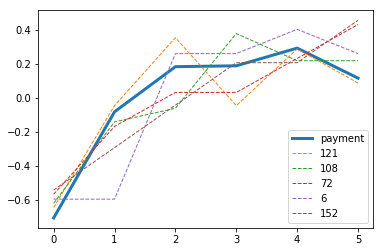

In [207]:
# Top 5 p-value, plotting
plt.plot(parent_payment_norm, linewidth=3, label='payment')
for i in range(0, 5):
    plt.plot(parent_loc_norm[sorted_cor_plpp[i][0]].tolist(), linewidth=1, linestyle='--', label=sorted_cor_plpp[i][0])
plt.legend()
plt.show()

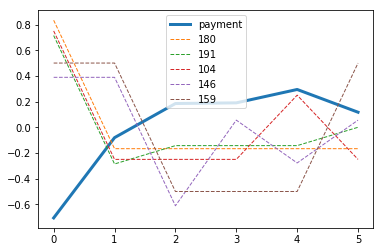

In [208]:
# Minor 5 p-value, plotting
plt.plot(parent_payment_norm, linewidth=3, label='payment')
for i in range(0, 5):
    plt.plot(parent_loc_norm[asc_sorted_cor_plpp[i][0]].tolist(), linewidth=1, linestyle='--', label=asc_sorted_cor_plpp[i][0])
plt.legend()
plt.show()

### Sitter location versus Parent payment count

In [209]:
# average pearson correlation (p-value)
p_sum = 0;
for k, v in cor_sitter_location_vs_parent_payment.iteritems():
    p_sum += v
    
p_avg = p_sum / len(cor_sitter_location_vs_parent_payment)
print p_avg

0.354457466503017


In [210]:
# ranking (sort) p-value (desc)
sorted_cor_plpp = sorted(cor_sitter_location_vs_parent_payment.items(), key=operator.itemgetter(1), reverse=True)
sorted_cor_plpp

[(92L, 0.8622807151139315),
 (35L, 0.8503325054230668),
 (77L, 0.8503244450376304),
 (164L, 0.8461154647636903),
 (146L, 0.8322923661063016),
 (99L, 0.8307146402377336),
 (63L, 0.8303120450886804),
 (78L, 0.8280283285535617),
 (58L, 0.8234513865705609),
 (163L, 0.8164478045207331),
 (137L, 0.8153738980318542),
 (51L, 0.8030609174505926),
 (67L, 0.7878284863864692),
 (183L, 0.7864597367677137),
 (121L, 0.7726665135586366),
 (57L, 0.7677700682457128),
 (81L, 0.7529254930245525),
 (66L, 0.746409612040657),
 (60L, 0.74407852635571),
 (55L, 0.7419838159131208),
 (151L, 0.7380038239176829),
 (109L, 0.7334698640593585),
 (130L, 0.7332886716216835),
 (84L, 0.7330521652365255),
 (36L, 0.7297060530167833),
 (64L, 0.7230342326293316),
 (31L, 0.7214964858087017),
 (143L, 0.7174729490791598),
 (39L, 0.7137887891968446),
 (18L, 0.7111233584966768),
 (94L, 0.7108549357007202),
 (87L, 0.7106588837744879),
 (108L, 0.7046306445930421),
 (7L, 0.696456820535663),
 (111L, 0.6920735769814611),
 (1L, 0.68917

In [211]:
pd.DataFrame(sorted_cor_plpp, columns=['location_index', 'p-value']).to_csv('./sitter_location_vs_parent_payment.csv', encoding='utf-8')

In [212]:
# ranking (sort) p-value (asc)
asc_sorted_cor_plpp = sorted(cor_sitter_location_vs_parent_payment.items(), key=operator.itemgetter(1), reverse=False)
asc_sorted_cor_plpp

[(138L, -0.9537865102935233),
 (129L, -0.9408153268841671),
 (247L, -0.9408153268841671),
 (46L, -0.8679108181588258),
 (122L, -0.8309064030109174),
 (153L, -0.6700398928479956),
 (157L, -0.6202739480297581),
 (116L, -0.5848843211816952),
 (22L, -0.5810741837841881),
 (154L, -0.43364284862257424),
 (125L, -0.38002827270261375),
 (95L, -0.3489616230706559),
 (24L, -0.33599978697381894),
 (30L, -0.3130760740157283),
 (48L, -0.3053968464502896),
 (147L, -0.2777314618108242),
 (149L, -0.275018316489529),
 (142L, -0.22943375808988467),
 (150L, -0.1523836545607482),
 (71L, -0.13074058863491367),
 (172L, -0.1076209414516944),
 (175L, -0.1076209414516944),
 (176L, -0.1076209414516944),
 (177L, -0.1076209414516944),
 (178L, -0.1076209414516944),
 (182L, -0.1076209414516944),
 (187L, -0.1076209414516944),
 (248L, -0.1076209414516944),
 (140L, -0.09364172310969707),
 (166L, -0.091747221137145),
 (110L, -0.06827347366523707),
 (190L, -0.023405814169321606),
 (52L, -0.01752189096082542),
 (120L, -0

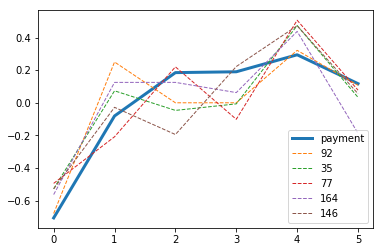

In [213]:
# Top 5 p-value, plotting
plt.plot(parent_payment_norm, linewidth=3, label='payment')
for i in range(0, 5):
    plt.plot(sitter_loc_norm[sorted_cor_plpp[i][0]].tolist(), linewidth=1, linestyle='--', label=sorted_cor_plpp[i][0])
plt.legend()
plt.show()

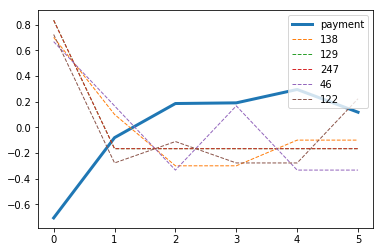

In [214]:
# Minor 5 p-value, plotting
plt.plot(parent_payment_norm, linewidth=3, label='payment')
for i in range(0, 5):
    plt.plot(sitter_loc_norm[asc_sorted_cor_plpp[i][0]].tolist(), linewidth=1, linestyle='--', label=asc_sorted_cor_plpp[i][0])
plt.legend()
plt.show()

## Output

In [215]:
locationDic.to_csv('./location_index.csv', encoding='utf-8')